<a href="https://colab.research.google.com/github/uol-mediaprocessing/group-projects-sudoku-solver/blob/master/main_acquisition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install import_ipynb
import import_ipynb

In [0]:
!wget https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-sudoku-solver/master/defs_common.ipynb -O "defs_common.ipynb"
from defs_common import *

--2020-01-03 07:54:22--  https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-sudoku-solver/master/defs_common.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6564 (6.4K) [text/plain]
Saving to: ‘defs_common.ipynb’

defs_common.ipynb   100%[===================>]   6.41K  --.-KB/s    in 0s      

2020-01-03 07:54:22 (101 MB/s) - ‘defs_common.ipynb’ saved [6564/6564]



In [0]:
import os
import re
from skimage import io
import cv2 as cv
import pandas as pd

# Introduction

Our goal is to solve a Sudoku puzzle which is contained within an image (or stream of images).
Thus, first of all, we have to acquire some images to be analyzed.
Because we want to train and evaluate different classifiers later on, we also provide the digits that are shown within each image.

We are using two datasets: One that we have found on the internet and another one we have built ourselves.
The merged dataset that we are building will be split into a subset for training and another one for testing/validation purposes.
This will be done by flagging input samples with either `training = True` or `training = False` respectively.
The rough percentage of data to be used for training is specified by the `TRAINING_PROB` variable. 

In [0]:
TRAINING_PROB = 0.8

Because of the large amount of data we are acquiring, we resize each input image to a fixed size upon import.
Otherwise the data would not fit into RAM and we would have to use some sort of generator that dynamically loads information from the disk.
We have to keep in mind, that the resolution defined by `INPUT_IMAGE_SIZE` is going to be crucial for the quality of our analysis.
Too small of an `INPUT_IMAGE_SIZE` and we possibly won't even detect the Sudoku puzzle's contours completely as they will be too thin - too large and our dataset won't fit into RAM.

In [0]:
INPUT_IMAGE_SIZE = (512, 512)

# Publicly available Sudoku dataset

This dataset is freely available as a [GitHub repository](https://github.com/wichtounet/sudoku_dataset). We are using the "train" subset containing roughly 160 images labelled with the respective digits. The images were taken using different cameras. No handwritten digits are included.

## Download

First we have to download the dataset from GitHub for which we are using the `wget` command.

In [0]:
!wget https://github.com/wichtounet/sudoku_dataset/blob/master/datasets/v2_train.tar.bz2?raw=true -O "v2_train.tar.bz2"

--2020-01-03 07:54:24--  https://github.com/wichtounet/sudoku_dataset/blob/master/datasets/v2_train.tar.bz2?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/wichtounet/sudoku_dataset/raw/master/datasets/v2_train.tar.bz2 [following]
--2020-01-03 07:54:24--  https://github.com/wichtounet/sudoku_dataset/raw/master/datasets/v2_train.tar.bz2
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wichtounet/sudoku_dataset/master/datasets/v2_train.tar.bz2 [following]
--2020-01-03 07:54:24--  https://raw.githubusercontent.com/wichtounet/sudoku_dataset/master/datasets/v2_train.tar.bz2
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

## Extraction

Then we extract the downloaded archive using the `tar` command.

In [0]:
!tar xvfj "v2_train.tar.bz2"

v2_train/image1.jpg
v2_train/image10.jpg
v2_train/image100.jpg
v2_train/image1000.jpg
v2_train/image1001.jpg
v2_train/image1003.jpg
v2_train/image1004.jpg
v2_train/image1006.jpg
v2_train/image1007.jpg
v2_train/image1008.jpg
v2_train/image101.jpg
v2_train/image1011.jpg
v2_train/image1014.jpg
v2_train/image1062.jpg
v2_train/image102.jpg
v2_train/image1020.jpg
v2_train/image1022.jpg
v2_train/image103.jpg
v2_train/image1031.jpg
v2_train/image1036.jpg
v2_train/image1038.jpg
v2_train/image1039.jpg
v2_train/image104.jpg
v2_train/image1040.jpg
v2_train/image1043.jpg
v2_train/image1045.jpg
v2_train/image1048.jpg
v2_train/image1049.jpg
v2_train/image105.jpg
v2_train/image1050.jpg
v2_train/image1055.jpg
v2_train/image1059.jpg
v2_train/image106.jpg
v2_train/image1066.jpg
v2_train/image1067.jpg
v2_train/image107.jpg
v2_train/image1070.jpg
v2_train/image1075.jpg
v2_train/image1076.jpg
v2_train/image1077.jpg
v2_train/image1078.jpg
v2_train/image1081.jpg
v2_train/image1082.jpg
v2_train/image1083.jpg
v

## Reading dataset

The dataset consists of images and their respective labels that will be read using the methods `read_image_data(...)` and `read_digits_txt(...)` that will be described in the following.

### Reading input image data

The image data can be simply read using the `read_image_data(...)` method which in turn calls the method `imread(...)` of the `skimage.io` package.
This method reads the file from a given input filename and returns an *RGB* encoded 3D-Numpy matrix with shape `(height, width, 3)`.

In [0]:
def read_image_data(filename):
  image = io.imread(filename)
  image = cv.resize(image, INPUT_IMAGE_SIZE, interpolation=cv.INTER_AREA)
  return image

### Reading input image labels

The labels for each image are stored within a file having the same base name as the image but ending with `.dat`. The first line states the camera that has been used to capture the image. The second line contains the X and Y resolution, bit depth and file type. The next 9 lines then contain the actual digits delimited by spaces and line breaks.

For example `image1.dat`, which contains the digits of `image1.jpg`, looks like this:

```
sonyEricsson s500i
640x480:24 JPG
0 0 0 7 0 0 0 8 0 
0 9 0 0 0 3 1 0 0 
0 0 6 8 0 5 0 7 0 
0 2 0 6 0 0 0 4 9 
0 0 0 2 0 0 0 5 0 
0 0 8 0 4 0 0 0 7 
0 0 0 9 0 0 0 3 0 
3 7 0 0 0 0 0 0 6 
1 0 5 0 0 4 0 0 0
```

We wrote a simple parser called `parse_digits_txt(...)` that iterates over all lines and uses regular expressions from the `re` package to find all digits contained therein.
This method is fed by `read_digits_txt(...)` which actually reads the input file contents and optionally skips a parameterized number of first lines (in this case 2).

In [0]:
def parse_digits_txt(lines):
  rows = []
  for line in lines:
    digits = re.findall("\d", line)
    digits = [int(x) for x in digits]
    rows.append(digits)
  return np.array(rows)

def read_digits_txt(filename, n_line_skip=0):
  with open(filename, "r") as file:
    lines = file.readlines()
    lines = lines[n_line_skip:]
    return parse_digits_txt(lines)

### Algorithm

The import algorithm in `read_v2_train(...)` itself works by searching for all `.jpg` files, reading their image data, replacing the extensions by `.dat`, reading their digits and finally building a Pandas `DataFrame` from that information.  

In [0]:
def read_v2_train(base_dir="./v2_train"):
  df_filename = []
  df_image = []
  df_digits = []
  df_training = []
  for filename in os.listdir(base_dir):
    if not filename.endswith(".jpg"):
      continue
    print("Discovered image '%s'! " % filename, end="")
    image_filename = os.path.join(base_dir, filename)
    df_filename.append(image_filename)
    print("Reading image data from '%s'... " % image_filename, end="")
    image_data = read_image_data(image_filename)
    print("Done! Shape = %s. " % (image_data.shape,), end="")
    df_image.append(image_data)
    meta_filename = image_filename[:-4] + ".dat"
    print("Reading meta data from '%s'... " % meta_filename, end="")
    meta_digits = read_digits_txt(meta_filename, 2)
    print("Done! Shape = %s." % (meta_digits.shape,))
    df_digits.append(meta_digits)
    training = random.random() < TRAINING_PROB
    df_training.append(training)
  return pd.DataFrame({
      "input_filename": df_filename,
      "input_image": df_image,
      "input_digits": df_digits,
      "training": df_training
  }).set_index("input_filename")

public_dataset = read_v2_train()

Discovered image 'image1059.jpg'! Reading image data from './v2_train/image1059.jpg'... Done! Shape = (512, 512, 3). Reading meta data from './v2_train/image1059.dat'... Done! Shape = (9, 9).
Discovered image 'image26.jpg'! Reading image data from './v2_train/image26.jpg'... Done! Shape = (512, 512, 3). Reading meta data from './v2_train/image26.dat'... Done! Shape = (9, 9).
Discovered image 'image41.jpg'! Reading image data from './v2_train/image41.jpg'... Done! Shape = (512, 512, 3). Reading meta data from './v2_train/image41.dat'... Done! Shape = (9, 9).
Discovered image 'image19.jpg'! Reading image data from './v2_train/image19.jpg'... Done! Shape = (512, 512, 3). Reading meta data from './v2_train/image19.dat'... Done! Shape = (9, 9).
Discovered image 'image22.jpg'! Reading image data from './v2_train/image22.jpg'... Done! Shape = (512, 512, 3). Reading meta data from './v2_train/image22.dat'... Done! Shape = (9, 9).
Discovered image 'image1006.jpg'! Reading image data from './v2_

## Visualization

This resulting `public_dataset` dataframe looks as follows:

In [0]:
public_dataset

,input_image,input_digits,training
input_filename,,,
./v2_train/image1059.jpg,"[[[172, 171, 159], [174, 170, 165], [174, 170,...","[[0, 3, 0, 1, 4, 8, 2, 0, 0], [0, 4, 2, 0, 0, ...",True
./v2_train/image26.jpg,"[[[120, 130, 131], [119, 129, 130], [117, 127,...","[[6, 0, 1, 0, 8, 5, 0, 0, 4], [0, 0, 0, 3, 0, ...",True
./v2_train/image41.jpg,"[[[142, 162, 150], [142, 162, 150], [142, 162,...","[[7, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 1, 4, 0, ...",True
./v2_train/image19.jpg,"[[[148, 166, 154], [148, 166, 154], [147, 165,...","[[6, 0, 1, 0, 8, 5, 0, 0, 4], [0, 0, 0, 3, 0, ...",False
./v2_train/image22.jpg,"[[[149, 166, 156], [149, 166, 156], [149, 166,...","[[6, 0, 1, 0, 8, 5, 0, 0, 4], [0, 0, 0, 3, 0, ...",False
...,...,...,...
./v2_train/image105.jpg,"[[[157, 170, 160], [157, 170, 160], [156, 169,...","[[9, 0, 3, 0, 0, 0, 0, 0, 2], [0, 6, 0, 4, 9, ...",True
./v2_train/image1008.jpg,"[[[174, 157, 142], [171, 156, 142], [169, 155,...","[[0, 3, 0, 0, 0, 0, 0, 4, 0], [0, 0, 0, 5, 0, ...",True
./v2_train/image109.jpg,"[[[140, 161, 154], [140, 161, 154], [139, 160,...","[[0, 0, 0, 7, 0, 0, 0, 8, 0], [0, 9, 0, 0, 0, ...",True


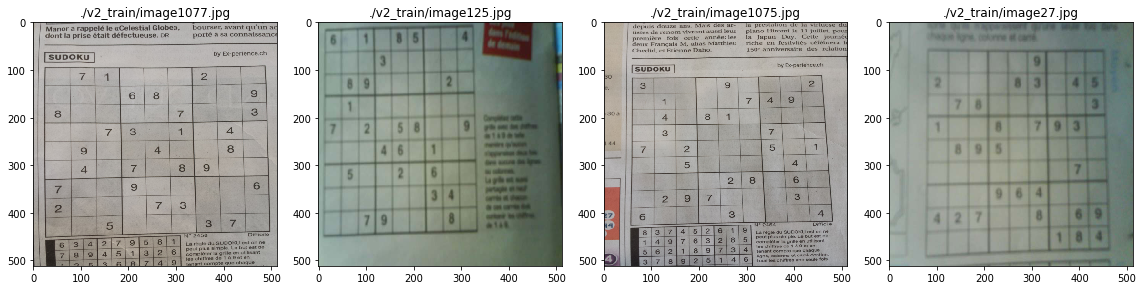

------------------------------------- ------------------------------------- ------------------------------------- -------------------------------------
|   | 7 | 1 |   |   |   | 2 |   |   | | 6 |   | 1 |   | 8 | 5 |   |   | 4 | | 3 |   |   |   | 9 |   |   |   | 2 | |   |   |   |   |   | 9 |   |   |   |
------------------------------------- ------------------------------------- ------------------------------------- -------------------------------------
|   |   |   | 6 | 8 |   |   |   | 9 | |   |   |   | 3 |   |   |   |   |   | |   | 1 |   |   |   | 7 | 4 | 9 |   | | 2 |   |   |   | 8 | 3 |   | 4 | 5 |
------------------------------------- ------------------------------------- ------------------------------------- -------------------------------------
| 8 |   |   |   |   | 7 |   |   | 3 | |   | 8 | 9 |   |   |   |   | 2 |   | |   | 4 |   | 8 | 1 |   |   |   |   | |   | 7 | 8 |   |   |   |   |   | 3 |
------------------------------------- ------------------------------------- ------------

In [0]:
subset = public_dataset.sample(n=4)
show_images(subset["input_image"], subset.index, rows=1, scaling=(4, 4))
print_grids(subset["input_digits"])

# Custom Sudoku dataset

Our custom Sudoku dataset consists of a set of albums.
Each album contains images of exactly one Sudoku puzzle from different perspectives and different lighting conditions.
Within each album there is also a file called `digits.txt` that lists the actual digits visible in each image. 

### Download

Because of its large file size and restrictions of GitHub we store the dataset on Google Drive.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The dataset is then copied from Google Drive to the local storage.

In [0]:
!cp "./drive/My Drive/dataset.zip" "./dataset.zip"

### Extraction

There the archive contents are extracted.

In [0]:
!unzip -o "./dataset.zip"

Archive:  ./dataset.zip
  inflating: dataset/000000701/digits.txt  
  inflating: dataset/000000701/IMG_8767.JPG  
  inflating: dataset/000000701/IMG_8768.JPG  
  inflating: dataset/000000701/IMG_8769.JPG  
  inflating: dataset/000000701/IMG_8770.JPG  
  inflating: dataset/000000701/IMG_8771.JPG  
  inflating: dataset/000000701/IMG_8772.JPG  
  inflating: dataset/000000701/IMG_8773.JPG  
  inflating: dataset/000000701/IMG_8774.JPG  
  inflating: dataset/000000701/IMG_8775.JPG  
  inflating: dataset/000000701/IMG_8776.JPG  
  inflating: dataset/000000701/IMG_8778.JPG  
  inflating: dataset/000000701/IMG_8779.JPG  
  inflating: dataset/000000701/IMG_8780.JPG  
  inflating: dataset/000000701/IMG_8781.JPG  
  inflating: dataset/000000701/IMG_8782.JPG  
  inflating: dataset/000000701/IMG_8783.JPG  
  inflating: dataset/000000701/IMG_8784.JPG  
  inflating: dataset/000000701/IMG_8785.JPG  
  inflating: dataset/000000701/IMG_8786.JPG  
  inflating: dataset/000000701/IMG_8787.JPG  
  inflating:

### Reading dataset

The reading process follows the same basic principles as used for reading the public dataset.
One important difference is that we have to decide on a per-*album* basis whether or not we include images in the training/validation dataset.
Otherwise we could include images of the same puzzle both inside the training *and* the validation dataset.
That would be bad.

In [0]:
def read_custom_dataset(base_dir="./dataset"):
  df_filename = []
  df_image = []
  df_digits = []
  df_training = []
  for album_name in os.listdir(base_dir):
    album_path = os.path.join(base_dir, album_name)
    print("Discovered album '%s'! " % album_path, end="")
    training = random.random() < TRAINING_PROB
    if training:
      print("(used for training)")
    else:
      print("(NOT used for training)")
    digits_path = os.path.join(album_path, "digits.txt")
    print("Reading digits from '%s'... " % digits_path, end="")
    digits = read_digits_txt(digits_path)
    print("Done! Shape = %s." % (digits.shape,))
    for image_name in os.listdir(album_path):
      if image_name.endswith(".txt"):
        continue # ignore txt files
      print("Discovered image '%s'! " % image_name, end="")
      image_path = os.path.join(album_path, image_name)
      df_filename.append(image_path)
      df_digits.append(digits)
      print("Reading image data from '%s'... " % image_path, end="")
      image_data = read_image_data(image_path)
      print("Done! Shape = %s." % (image_data.shape,))
      df_image.append(image_data)
      df_training.append(training)
  return pd.DataFrame({
      "input_filename": df_filename,
      "input_image": df_image,
      "input_digits": df_digits,
      "training": df_training
  }).set_index("input_filename")

custom_dataset = read_custom_dataset()

Discovered album './dataset/023004000'! (used for training)
Reading digits from './dataset/023004000/digits.txt'... Done! Shape = (9, 9).
Discovered image 'IMG_8766.JPG'! Reading image data from './dataset/023004000/IMG_8766.JPG'... Done! Shape = (512, 512, 3).
Discovered image 'IMG_8755.JPG'! Reading image data from './dataset/023004000/IMG_8755.JPG'... Done! Shape = (512, 512, 3).
Discovered image 'IMG_8762.JPG'! Reading image data from './dataset/023004000/IMG_8762.JPG'... Done! Shape = (512, 512, 3).
Discovered image 'IMG_8764.JPG'! Reading image data from './dataset/023004000/IMG_8764.JPG'... Done! Shape = (512, 512, 3).
Discovered image 'IMG_8754.JPG'! Reading image data from './dataset/023004000/IMG_8754.JPG'... Done! Shape = (512, 512, 3).
Discovered image 'IMG_8756.JPG'! Reading image data from './dataset/023004000/IMG_8756.JPG'... Done! Shape = (512, 512, 3).
Discovered image 'IMG_8758.JPG'! Reading image data from './dataset/023004000/IMG_8758.JPG'... Done! Shape = (512, 512

## Visualization

This resulting `custom_dataset` dataframe looks as follows:

In [0]:
custom_dataset

,input_image,input_digits,training
input_filename,,,
./dataset/023004000/IMG_8766.JPG,"[[[130, 120, 122], [131, 119, 123], [132, 117,...","[[0, 2, 3, 0, 0, 4, 0, 0, 0], [8, 0, 5, 0, 0, ...",True
./dataset/023004000/IMG_8755.JPG,"[[[225, 225, 227], [227, 224, 230], [226, 224,...","[[0, 2, 3, 0, 0, 4, 0, 0, 0], [8, 0, 5, 0, 0, ...",True
./dataset/023004000/IMG_8762.JPG,"[[[132, 115, 99], [133, 113, 100], [132, 113, ...","[[0, 2, 3, 0, 0, 4, 0, 0, 0], [8, 0, 5, 0, 0, ...",True
./dataset/023004000/IMG_8764.JPG,"[[[154, 147, 146], [154, 145, 146], [155, 146,...","[[0, 2, 3, 0, 0, 4, 0, 0, 0], [8, 0, 5, 0, 0, ...",True
./dataset/023004000/IMG_8754.JPG,"[[[157, 149, 115], [139, 127, 98], [130, 119, ...","[[0, 2, 3, 0, 0, 4, 0, 0, 0], [8, 0, 5, 0, 0, ...",True
...,...,...,...
./dataset/009000800/IMG_8812.JPG,"[[[93, 98, 90], [95, 96, 95], [93, 95, 94], [9...","[[0, 0, 9, 0, 0, 0, 8, 0, 0], [0, 6, 0, 0, 0, ...",True
./dataset/009000800/IMG_8817.JPG,"[[[195, 195, 197], [196, 194, 200], [195, 196,...","[[0, 0, 9, 0, 0, 0, 8, 0, 0], [0, 6, 0, 0, 0, ...",True
./dataset/009000800/IMG_8822.JPG,"[[[15, 15, 14], [15, 15, 17], [14, 14, 16], [1...","[[0, 0, 9, 0, 0, 0, 8, 0, 0], [0, 6, 0, 0, 0, ...",True


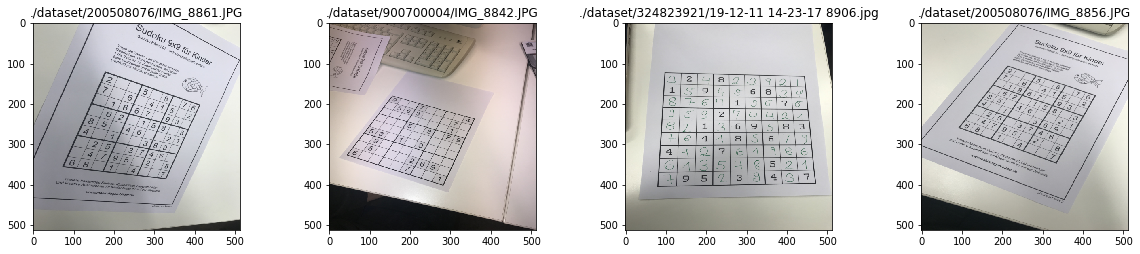

------------------------------------- ------------------------------------- ------------------------------------- -------------------------------------
| 2 |   |   | 5 |   | 8 |   | 7 | 6 | | 9 |   |   | 7 |   |   |   |   | 4 | | 3 | 2 | 4 | 8 | 2 | 3 | 9 | 2 | 1 | | 2 |   |   | 5 |   | 8 |   | 7 | 6 |
------------------------------------- ------------------------------------- ------------------------------------- -------------------------------------
| 7 |   | 6 |   | 4 | 1 | 5 |   | 2 | |   | 5 | 6 | 3 |   |   |   | 7 |   | | 1 | 5 | 9 | 4 | 5 | 6 | 8 | 3 | 4 | | 7 |   | 6 |   | 4 | 1 | 5 |   | 2 |
------------------------------------- ------------------------------------- ------------------------------------- -------------------------------------
|   | 1 | 8 | 6 | 7 |   | 9 | 3 |   | |   |   |   |   |   |   |   | 1 |   | | 8 | 7 | 6 | 7 | 1 | 9 | 6 | 7 | 5 | |   | 1 | 8 | 6 | 7 |   | 9 | 3 |   |
------------------------------------- ------------------------------------- ------------

In [0]:
subset = custom_dataset.sample(n=4)
show_images(subset["input_image"], subset.index, rows=1, scaling=(4, 4))
print_grids(subset["input_digits"])

# Merging the datasets

Finally the `public_dataset` and `custom_dataset` are merged by concatenating their respective rows.

In [0]:
dataset = pd.concat([public_dataset, custom_dataset])

In [0]:
dataset

,input_image,input_digits,training
input_filename,,,
./v2_train/image1059.jpg,"[[[172, 171, 159], [174, 170, 165], [174, 170,...","[[0, 3, 0, 1, 4, 8, 2, 0, 0], [0, 4, 2, 0, 0, ...",True
./v2_train/image26.jpg,"[[[120, 130, 131], [119, 129, 130], [117, 127,...","[[6, 0, 1, 0, 8, 5, 0, 0, 4], [0, 0, 0, 3, 0, ...",True
./v2_train/image41.jpg,"[[[142, 162, 150], [142, 162, 150], [142, 162,...","[[7, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 1, 4, 0, ...",True
./v2_train/image19.jpg,"[[[148, 166, 154], [148, 166, 154], [147, 165,...","[[6, 0, 1, 0, 8, 5, 0, 0, 4], [0, 0, 0, 3, 0, ...",False
./v2_train/image22.jpg,"[[[149, 166, 156], [149, 166, 156], [149, 166,...","[[6, 0, 1, 0, 8, 5, 0, 0, 4], [0, 0, 0, 3, 0, ...",False
...,...,...,...
./dataset/009000800/IMG_8812.JPG,"[[[93, 98, 90], [95, 96, 95], [93, 95, 94], [9...","[[0, 0, 9, 0, 0, 0, 8, 0, 0], [0, 6, 0, 0, 0, ...",True
./dataset/009000800/IMG_8817.JPG,"[[[195, 195, 197], [196, 194, 200], [195, 196,...","[[0, 0, 9, 0, 0, 0, 8, 0, 0], [0, 6, 0, 0, 0, ...",True
./dataset/009000800/IMG_8822.JPG,"[[[15, 15, 14], [15, 15, 17], [14, 14, 16], [1...","[[0, 0, 9, 0, 0, 0, 8, 0, 0], [0, 6, 0, 0, 0, ...",True


# Export

The current state of the dataset has to be saved for for further processing. That way we don't have to execute the whole pipeline again each time we update our software. 

In [0]:
dataset.to_pickle("sudoku_acquisition_output.bz2")

As we are currently working with *Google Colab* our data is not persistenly stored.
We have to store the generated output somewhere else.
For that we are using *Google Drive*.
Each stage of the pipeline has to mount the user's Google Drive directory and copy the previous stage's output to its own local storage for further analysis.

In [0]:
!cp "./sudoku_acquisition_output.bz2" "./drive/My Drive/sudoku_acquisition_output.bz2"